In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import numpy as np
import scipy.sparse
from pathlib import Path

from tqdm import tqdm
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [26]:
# check if GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available")
    device = torch.device("cpu")
print("Using device: ", device)

GPU is available
Using device:  cuda


# y label

In [32]:
ticks_tiles_newlined = [
    "1\nman",
    "2\nman",
    "3\nman",
    "4\nman",
    "5\nman",
    "6\nman",
    "7\nman",
    "8\nman",
    "9\nman",
    "1\npin",
    "2\npin",
    "3\npin",
    "4\npin",
    "5\npin",
    "6\npin",
    "7\npin",
    "8\npin",
    "9\npin",
    "1\nsou",
    "2\nsou",
    "3\nsou",
    "4\nsou",
    "5\nsou",
    "6\nsou",
    "7\nsou",
    "8\nsou",
    "9\nsou",
    "\nEast",
    "\nSouth",
    "\nWest",
    "\nNorth",
    "\nHaku",
    "\nHatsu",
    "\nChun"
]

ticks_tiles_oneline = [
    "1 man",
    "2 man",
    "3 man",
    "4 man",
    "5 man",
    "6 man",
    "7 man",
    "8 man",
    "9 man",
    "1 pin",
    "2 pin",
    "3 pin",
    "4 pin",
    "5 pin",
    "6 pin",
    "7 pin",
    "8 pin",
    "9 pin",
    "1 sou",
    "2 sou",
    "3 sou",
    "4 sou",
    "5 sou",
    "6 sou",
    "7 sou",
    "8 sou",
    "9 sou",
    "East",
    "South",
    "West",
    "North",
    "Haku",
    "Hatsu",
    "Chun"
]

# Load dataset

In [3]:
def get_balanced_data_options(code: str):
    results = [False, False, False]
    code = int(f"0b{code:0>11}", 2)
    results[0] = code & 0b100 != 0
    results[1] = code & 0b010 != 0
    results[2] = code & 0b001 != 0
    return results

In [4]:
from enum import Enum

class DiscardDataset(torch.utils.data.Dataset):
    
    class DiscardType(Enum):
        DISCARD = 0
        POOL    = 1

    def __init__(self, data_path, years: list, n_rows: int = None, phase: int = None, balance_data: bool = False, discard_type=DiscardType.DISCARD, singular=False):
        """ 
        If n_rows = None -> get all 
        param: singular: If True, pick 1 state per game at random!
        """ 
        
        # FORCE SEED
        torch.manual_seed(0)
        np.random.seed(0)
        
        # Invalid Parameter Combinations
        if balance_data:
            if not n_rows:
                raise BaseException("`n_rows` must be defined if `balance_data` is True!")
            elif n_rows < 34:
                raise BaseException("Cannot balance data if `n_rows` < 34!")
        
        # ALL_YEARS = (2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019)
        # invalid_years = set(years) - set(ALL_YEARS)
        # if invalid_years:
        #     raise Exception(f"INVALID YEARS: {invalid_years}")
        
        # Dataset Print
        if n_rows:
            print(f"Loading Dataset with {n_rows:>13,} rows", end=' ')
        else:
            print(f"Loading Dataset with all rows", end=' ')

        if phase in [0, 1, 2]:
            print(f"(Phase {phase})", end=' ')
        else:
            print(f"(All Phases)", end=' ')
            
        print("{:<14}".format("<BALANCED>" if balance_data else '<NOT BALANCED>'), end=' ')
        
        # print(years)
        
        # Check if given discard_type is valid
        if discard_type not in [DiscardDataset.DiscardType.DISCARD, DiscardDataset.DiscardType.POOL]:
            raise BaseException(f"INVALID discard type = {discard_type}! Use either `DiscardDataset.DISCARD` or `DiscardDataset.POOL`!")
        self.discard_type = discard_type

        game_id_list = []
        temp_matrices = []
        finished = False
        
        # Used when balance_data = False and n_rows != None
        loaded_rows = 0  
        
        # Used when balance_data = True
        class_bins = np.zeros(34)
        baseline_bin_size = n_rows // 34 if balance_data else -1  # The expected size of the smallest bin

        if balance_data:
            paths_load_bar = tqdm(total=baseline_bin_size * 34, unit='rows', position=0)
        else:
            paths_load_bar = tqdm(total=n_rows, unit='rows', position=0)

        # for year in years:
        year = 2019

        paths = data_path.iterdir()

        for idx, path in enumerate(paths):
            
            if path.suffix != '.npz':
                continue
            
            game_id_list.append(path.stem)

            arr = scipy.sparse.load_npz(path).toarray()  # Loads a single complete game

            if phase in [0, 1, 2]:
                phased_matrices = self.generate_phase_column(arr)
                arr = phased_matrices[phase]
                
            if singular:
                if arr.shape[0] <= 0:  # No rows found (This can happen if a game lack states from a certain phase)
                    continue
                random_row_index = np.random.choice(arr.shape[0], 1, replace=False)
                arr = arr[random_row_index]  # Select 1 row per loaded game

            temp_matrices.append(arr)

            paths_load_bar.set_postfix(year=year, files_loaded=(idx + 1))  # Update Bar

            if balance_data:
                
                class_bins += np.bincount(arr[:, -1], minlength=34)
                smallest_class_bin = int(np.amin(class_bins))

                paths_load_bar.n = smallest_class_bin * 34
                paths_load_bar.refresh()
                
                if baseline_bin_size <= smallest_class_bin:
                    finished = True
                    break

            else:
                paths_load_bar.update(arr.shape[0])
                
                if n_rows:
                    loaded_rows += arr.shape[0]
                    if n_rows <= loaded_rows:
                        finished = True
                        break

        # if finished:  # Early Stopping
        #     break

        if not finished and n_rows is not None:
            raise BaseException("`n_rows` is higher than found rows -- Either lower `n_rows` or include more annual datasets!")

        new_game_id_list = []
        for i, t_matrix in enumerate(temp_matrices):
            new_game_id_list.extend([game_id_list[i]] * t_matrix.shape[0])
        new_game_id_list = np.array(new_game_id_list)
        
        if balance_data:
            
            matrix = np.concatenate(temp_matrices, axis=0)
            sorted_indices = np.argsort(matrix[:, -1])
            
            matrix = matrix[sorted_indices]  # Sort rows by last column (the y-value)
            new_game_id_list = new_game_id_list[sorted_indices]
            
            split_indices = np.where(np.diff(matrix[:, -1])!=0)[0]+1  # I was drunk
            sorted_rows = np.array_split(matrix, split_indices)  # Organize rows according to their last column's value into a list
            sorted_game_ids = np.array_split(new_game_id_list, split_indices)
            
            for i in range(len(sorted_rows)):
                sorted_rows[i] = sorted_rows[i][:baseline_bin_size]  # The balancing action
                sorted_game_ids[i] = sorted_game_ids[i][:baseline_bin_size]

            final_arr = np.concatenate(sorted_rows, axis=0)
            final_game_id_list = np.concatenate(sorted_game_ids, axis=0)

        else:
            final_arr = np.vstack(temp_matrices)
            final_game_id_list = new_game_id_list
            
            if n_rows:
                final_arr = final_arr[:n_rows]
                final_game_id_list = final_game_id_list[:n_rows]
                
        # Extract Round Number and Steps from data
        self.round_numbers = final_arr[:, 32].reshape(-1).tolist()
        self.step_numbers  = (final_arr[:, 33] + 128 - 1).reshape(-1).tolist()        
        final_arr[:, 32] = -128  # Reset to padding value
        final_arr[:, 33] = -128  # Reset to padding value

        # Finalize tqdm bar
        paths_load_bar.n = final_arr.shape[0]
        paths_load_bar.last_print_n = final_arr.shape[0]
        paths_load_bar.refresh()
        paths_load_bar.close()
        
        self.game_ids = list(final_game_id_list)
        self.combined_x_data = torch.FloatTensor(final_arr[:, :-1])  # Must be Float it seems
        
        self.x_data = None
        if self.discard_type == DiscardDataset.DiscardType.POOL:
            self.use_pools()
        else:
            self.use_discards()
        
        self.y_data = torch.LongTensor(final_arr[:, -1])  # Must be Long it seems
        
    def use_pools(self):
        self.discard_type = DiscardDataset.DiscardType.POOL
        self.x_data = self.combined_x_data[:, 0:374]

    def use_discards(self):
        self.discard_type = DiscardDataset.DiscardType.DISCARD
        self.x_data = torch.hstack((self.combined_x_data[:, :238], self.combined_x_data[:, 374:]))  # Slice away POOL data
    
    @staticmethod
    def generate_phase_column(array: np.array) -> np.array:
        # Begin with merging all pools together

        merged_discards = array[:, 238:374]  # Pool
        merged_discards = np.sum(merged_discards, axis=1)

        phases = np.zeros([array.shape[0]])  # Early Game
        phases[(24 < merged_discards) & (merged_discards <= 48)] = 1  # Mid Game
        phases[(48 < merged_discards)] = 2  # End Game

        return array[(phases == 0)], array[(phases == 1)], array[(phases == 2)]        

    def __len__(self):
        return self.x_data.shape[0]

    def __getitem__(self, idx):
#         X = self.x_data[idx, 0:374] if self.discard_type == DiscardDataset.DiscardType.POOL else torch.hstack((self.x_data[idx, :238], self.x_data[idx, 374:]))
        return {
            'game_id': self.game_ids[idx],
            'round': self.round_numbers[idx],
            'step': self.step_numbers[idx],
            'X': self.x_data[idx],
            'y': self.y_data[idx]
        }

# Parameter

In [8]:
train_size = 40000
validation_size = 8000
test_size = 4000
batch_size = 32
balanced_data  = 111
PHASES = -1
DISCARD_TYPE = DiscardDataset.DiscardType.POOL
epochs = 100


# loading dataset

In [9]:
DATASET_PATH = Path('2019')

In [10]:
BALANCED_TRAINING, BALANCED_VALIDATION, BALANCED_TEST = get_balanced_data_options(balanced_data) 

train_dataset = DiscardDataset(DATASET_PATH,
                                   n_rows=train_size,
                                   years=[],
                                   phase=PHASES,
                                   balance_data=BALANCED_TRAINING,
                                   discard_type=DISCARD_TYPE
                                  )
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = DiscardDataset(DATASET_PATH,
                                        n_rows=validation_size,
                                        years=[],
                                        phase=PHASES,
                                        balance_data=BALANCED_VALIDATION,
                                        discard_type=DISCARD_TYPE,
                                        singular=True
                                       )

validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DiscardDataset(DATASET_PATH, 
                              n_rows=test_size, 
                              years=[],
                              phase=PHASES,
                              balance_data=BALANCED_TEST,
                              discard_type=DISCARD_TYPE,
                              singular=True
                             )

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

Loading Dataset with        40,000 rows (All Phases) <BALANCED>     

100%|██████████| 39984/39984 [00:00<00:00, 66641.12rows/s, files_loaded=351, year=2019]


Loading Dataset with         8,000 rows (All Phases) <BALANCED>     

100%|██████████| 7990/7990 [00:39<00:00, 203.79rows/s, files_loaded=30718, year=2019]


Loading Dataset with         4,000 rows (All Phases) <BALANCED>     

100%|██████████| 3978/3978 [00:20<00:00, 194.14rows/s, files_loaded=15856, year=2019]


In [11]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(39984, 7990, 3978)

In [12]:
len(test_dataset.x_data), len(test_dataset.game_ids)

(3978, 3978)

# datachecker


In [13]:
def count_corrupted_cases(dataset):
    """ Return indices of corrupted X datas. """
    if dataset is not None:
        return torch.nonzero(torch.sum(dataset.x_data[:, 68:102], dim=1) > 14).flatten().tolist()
    else:
        return []

corrupt_datasets = [count_corrupted_cases(train_dataset), count_corrupted_cases(validation_dataset), count_corrupted_cases(test_dataset)]
print(f"""Corrupted Dataset Indices:
    - Training Dataset:   {corrupt_datasets[0]}
    - Validation Dataset: {corrupt_datasets[1]}
    - Testing Dataset:    {corrupt_datasets[2]}
""")

assert len(corrupt_datasets[0]) == 0 and len(corrupt_datasets[1]) == 0 and len(corrupt_datasets[2]) == 0

Corrupted Dataset Indices:
    - Training Dataset:   []
    - Validation Dataset: []
    - Testing Dataset:    []



In [22]:
for batch in train_loader:
    x = batch['X']  # Assuming your dataset returns a dict with 'X' and 'y'
    y = batch['y']
    
    print("Input x shape:", x.shape)  # e.g., torch.Size([32, 374])
    print("Label y shape:", y.shape)  # e.g., torch.Size([32])
    
    print("First input sample (x[0]):", x[0])
    print("First label (y[0]):", y[0])
    break  # Only one batch

Input x shape: torch.Size([32, 374])
Label y shape: torch.Size([32])
First input sample (x[0]): tensor([   1.,    2.,    1.,    0.,    0.,   47.,   17.,   27.,   25.,   31.,
           0.,    0.,    0.,    0., -128., -128., -128., -128., -128., -128.,
        -128., -128., -128., -128., -128., -128., -128., -128., -128., -128.,
        -128., -128., -128., -128.,    0.,    0.,    0.,    0.,    1.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    2.,
           1.,    0.,    0.,    0.,    1.,    1.,    1.,    0.,    0.,    0.,
           0.,    0.,    0.,    1.,    1.,    1.,    0.,    0.,    0.,    1.,
           2.,    0.,    0.,    1.,    0.,    0.,    0.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    

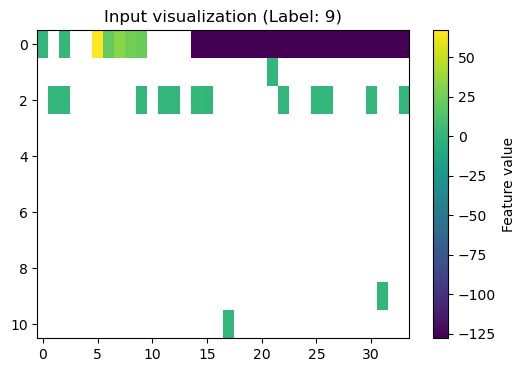

In [30]:
batch = next(iter(train_loader))
x = batch['X'][0].reshape(11, 34).cpu().numpy()  # adjust reshape as needed
y = batch['y'][0]

# Mask zero values
masked_x = np.ma.masked_where(x == 0, x)

# Create a colormap: 'viridis' with white for masked (zero) values
cmap = plt.cm.viridis
cmap.set_bad(color='white')  # White for masked areas

# Plot
plt.figure(figsize=(6, 4))
plt.imshow(masked_x, cmap=cmap, aspect='auto')
plt.title(f"Input visualization (Label: {y.item()})")
plt.colorbar(label="Feature value")
plt.show()

# Model

In [15]:
class Net(torch.nn.Module):
    """ Simple Feed-Forward Net """

    def __init__(self):
        super(Net, self).__init__()
        
        self.name = "BasicDenseNetwork_testing"
        
        self.fc1 = torch.nn.Linear(11 * 34, 1024)  # SWITCH TO 1024
        self.fc2 = torch.nn.Linear(1024, 512)      # SWITCH TO 1024
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, 34)
        
        self.relu_1 = torch.nn.LeakyReLU()
        self.relu_2 = torch.nn.LeakyReLU()
        self.relu_3 = torch.nn.LeakyReLU()
        self.relu_4 = torch.nn.LeakyReLU()

    def forward(self, x):
            
        x = self.fc1(x)
        x = self.relu_1(x)
        
        x = self.fc2(x)
        x = self.relu_2(x)
        
        x = self.fc3(x)
        x = self.relu_3(x)
        
        x = self.fc4(x)
        x = self.relu_4(x)
        
        x = self.fc5(x)

        return x

In [16]:
class BigAttentionNet(torch.nn.Module):
    """ Attention Layer into Bigger feed-forward net. """

    def __init__(self, n_heads):
        super(BigAttentionNet, self).__init__()
        
        self.name = f"MHA-{n_heads}"
#         print(self.name)
        
        self.mha1 = torch.nn.MultiheadAttention(embed_dim=374, 
                                                num_heads=n_heads,  # 1, 11, or 34 are doable
                                                dropout=0.0,   # Default: 0.0.
                                                add_zero_attn=False,  # Default: False - Have this false, from not so many experiments, it seems like it slows down learning accuracy by a almost unoticeable bit
                                               )

        self.fc1 = torch.nn.Linear(11 * 34, 4096)   # EXTRA LAYER
        self.fc2 = torch.nn.Linear(4096, 2048)      # EXTRA LAYER
        self.fc3 = torch.nn.Linear(2048, 1024)
        self.fc4 = torch.nn.Linear(1024, 512)
        self.fc5 = torch.nn.Linear(512, 256)
        self.fc6 = torch.nn.Linear(256, 128)
        self.fc7 = torch.nn.Linear(128, 34)
        
        self.relu_1 = torch.nn.LeakyReLU()
        self.relu_2 = torch.nn.LeakyReLU()
        self.relu_3 = torch.nn.LeakyReLU()
        self.relu_4 = torch.nn.LeakyReLU()
        self.relu_5 = torch.nn.LeakyReLU()
        self.relu_6 = torch.nn.LeakyReLU()


    def forward(self, x):
        
        batch_size = x.shape[0]
        x = x.reshape(1, batch_size, 374)  #  => x.shape[0] = Batch Size
        attn_output, attn_output_weights = self.mha1(query=x, key=x, value=x, need_weights=False)  # attn_output_weights = None, if need_weights=False
        x = attn_output.reshape(batch_size, 374)
        
        x = self.fc1(x)
        x = self.relu_1(x)
        
        x = self.fc2(x)
        x = self.relu_2(x)
        
        x = self.fc3(x)
        x = self.relu_3(x)
        
        x = self.fc4(x)
        x = self.relu_4(x)
        
        x = self.fc5(x)
        x = self.relu_5(x)
        
        x = self.fc6(x)
        x = self.relu_6(x)
        
        x = self.fc7(x)
        
        return x

In [17]:
torch.manual_seed(0)
np.random.seed(0)

model = Net().to(device)  # SWITCH ATTENTION
# model = BigNet().to(DEVICE)

criterion = torch.nn.CrossEntropyLoss().to(device)  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loaded_epoch = 0

model

Net(
  (fc1): Linear(in_features=374, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=34, bias=True)
  (relu_1): LeakyReLU(negative_slope=0.01)
  (relu_2): LeakyReLU(negative_slope=0.01)
  (relu_3): LeakyReLU(negative_slope=0.01)
  (relu_4): LeakyReLU(negative_slope=0.01)
)

In [18]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_params

1077410

In [ ]:
sample_input = torch.randn(32, 3, 64, 64).to(device)  # 根据你模型的输入形状
model.eval()
with torch.no_grad():
    output = model(sample_input)
print("Output shape:", output.shape)

ValueError: too many values to unpack (expected 2)

# Train

In [19]:
# Training Loop
def train_model(model, train_loader, validation_loader, criterion, optimizer, device, epochs):
    """
    Train the model and validate after each epoch.
    
    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for the training dataset.
        validation_loader: DataLoader for the validation dataset.
        criterion: Loss function.
        optimizer: Optimizer for training.
        device: Device to train on (CPU or GPU).
        epochs: Number of epochs to train.
    """
    model.train()  # Set the model to training mode

    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for batch in train_loader:
            inputs, labels = batch['X'].to(device), batch['y'].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss and accuracy
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Print training stats
        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

        # Validation loop
        validate_model(model, validation_loader, criterion, device)

def validate_model(model, validation_loader, criterion, device):
    """
    Validate the model on the validation dataset.
    
    Args:
        model: The PyTorch model to validate.
        validation_loader: DataLoader for the validation dataset.
        criterion: Loss function.
        device: Device to validate on (CPU or GPU).
    """
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in validation_loader:
            inputs, labels = batch['X'].to(device), batch['y'].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss and accuracy
            validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_accuracy = 100 * correct / total
    print(f"Validation Loss: {validation_loss:.4f}, Accuracy: {validation_accuracy:.2f}%")

    

In [20]:
train_model(model, train_loader, validation_loader, criterion, optimizer, device, epochs)

Epoch 1/100, Loss: 4415.4887, Accuracy: 2.82%
Validation Loss: 881.6554, Accuracy: 2.94%
Epoch 2/100, Loss: 4409.3244, Accuracy: 2.95%
Validation Loss: 881.6769, Accuracy: 2.94%
Epoch 3/100, Loss: 4408.5781, Accuracy: 2.77%
Validation Loss: 881.5956, Accuracy: 2.94%
Epoch 4/100, Loss: 4408.4916, Accuracy: 2.70%
Validation Loss: 881.6188, Accuracy: 2.94%
Epoch 5/100, Loss: 4410.9726, Accuracy: 2.76%
Validation Loss: 881.5993, Accuracy: 2.94%
Epoch 6/100, Loss: 4408.5147, Accuracy: 2.83%
Validation Loss: 881.5980, Accuracy: 2.94%
Epoch 7/100, Loss: 4409.4153, Accuracy: 2.89%
Validation Loss: 882.2313, Accuracy: 2.94%
Epoch 8/100, Loss: 4410.1892, Accuracy: 2.66%
Validation Loss: 881.6233, Accuracy: 2.94%
Epoch 9/100, Loss: 4409.6387, Accuracy: 2.91%
Validation Loss: 882.2626, Accuracy: 2.94%
Epoch 10/100, Loss: 4409.2690, Accuracy: 2.78%
Validation Loss: 881.6025, Accuracy: 2.94%
Epoch 11/100, Loss: 4409.6583, Accuracy: 2.83%
Validation Loss: 881.6080, Accuracy: 2.87%
Epoch 12/100, Loss: